# Classifying Images of Clothing

## Imports

In [2]:
import tensorflow as tf

In [3]:
#Import Tensorflow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt


In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

In [7]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [8]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Explore the data

In [10]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocess the data

In [12]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()



# Explore the processed data

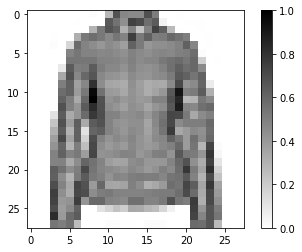

In [13]:
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

#Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

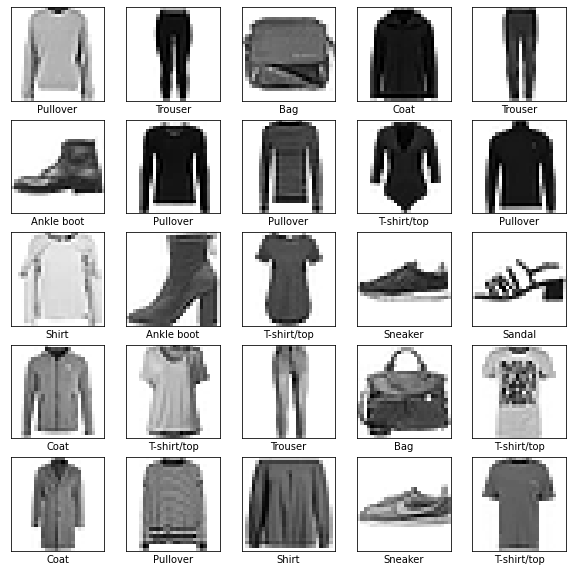

In [14]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

## Build the model

In [15]:
model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28,28,1)),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the Model

In [17]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [18]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 10s 2ms/step - loss: 0.4913 - accuracy: 0.8246
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3716 - accuracy: 0.8652
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3329 - accuracy: 0.8770
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3086 - accuracy: 0.8870
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2951 - accuracy: 0.8921


## Evaluate accuracy

In [19]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.3661 - accuracy: 0.8686
Accuracy on test dataset: 0.8686000108718872


## Make Predictions and explore

In [20]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [21]:
predictions.shape

(32, 10)

In [22]:
predictions[0]

array([7.4609779e-05, 4.3170926e-06, 3.5824914e-02, 7.9912461e-06,
       9.2623782e-01, 5.4395577e-09, 3.7840463e-02, 1.2931701e-08,
       9.7337843e-06, 1.4634719e-07], dtype=float32)

In [24]:
np.argmax(predictions[0])

4

In [25]:
test_labels[0]

4

In [26]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

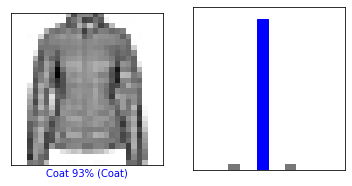

In [27]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

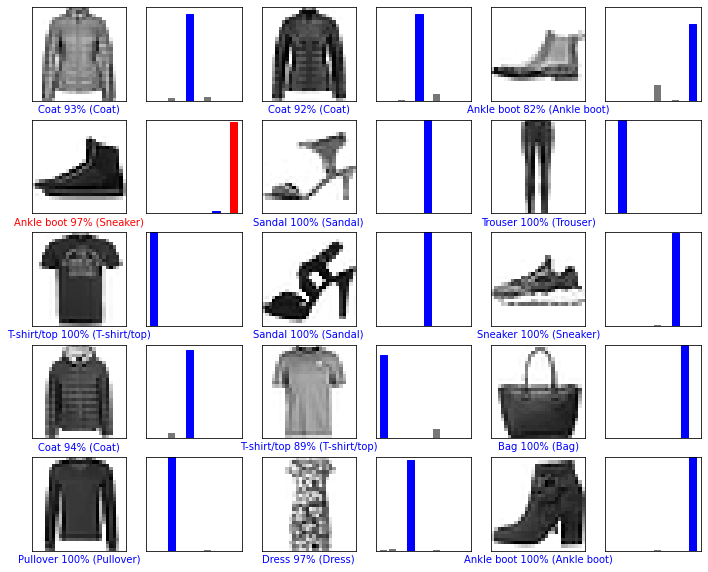

In [28]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


In [29]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [30]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [31]:
predictions_single = model.predict(img)

print(predictions_single)

[[7.4609838e-05 4.3170999e-06 3.5824921e-02 7.9912525e-06 9.2623770e-01
  5.4395466e-09 3.7840515e-02 1.2931724e-08 9.7337834e-06 1.4634716e-07]]


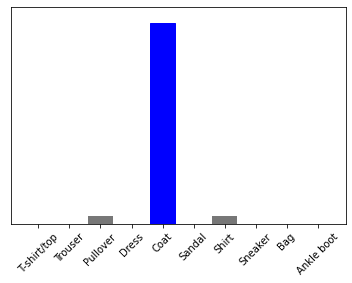

In [32]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [33]:
np.argmax(predictions_single[0])

4